In [56]:
# Import libraries 

import numpy as np    # Numeric and matrix computation
import pandas as pd   # Optional: good package for manipulating data 
import sklearn as sk  # Package with learning algorithms implemented
import matplotlib.pyplot as plt        # Per mostrar plots
import sklearn.datasets as ds            # Per carregar mÃ©s facilment el dataset digits
import sklearn.model_selection as cv    # Pel Cross-validation

def load_data():
  global df
  try: 
    df = pd.read_csv("../data/preprocessed.csv")
    
  except FileNotFoundError:
    from google.colab import drive
    drive.mount('/content/drive')
    df=pd.read_csv('/content/drive/MyDrive/MD/Laboratori/Practica 2/data/smoking.csv', header =None)

load_data()
df.head()


,age,height(cm),weight(kg),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,fasting blood sugar,Cholesterol,triglyceride,HDL,hemoglobin,Urine protein,serum creatinine,ALT,Gtp,dental caries,tartar,smoking
0,40,155,60,1.2,1.0,1.0,1.0,114.0,94.0,215.0,82.0,73.0,12.9,1.0,0.7,19.0,27.0,False,True,False
1,40,160,60,0.8,0.6,1.0,1.0,119.0,130.0,192.0,115.0,42.0,12.7,1.0,0.6,19.0,18.0,False,True,False
2,55,170,60,0.8,0.8,1.0,1.0,138.0,89.0,242.0,182.0,55.0,15.8,1.0,1.0,16.0,22.0,False,False,True
3,40,165,70,1.5,1.5,1.0,1.0,100.0,96.0,322.0,254.0,45.0,14.7,1.0,1.0,26.0,18.0,False,True,False
4,40,155,60,1.0,1.0,1.0,1.0,120.0,80.0,184.0,74.0,62.0,12.5,1.0,0.6,14.0,22.0,False,False,False


In [57]:
# Divide data between all dataset without smoking and smoking label

X = df.drop('smoking', axis=1)
y = df.smoking
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.3, random_state=1, stratify=y)

**Voting scheme**

*Naïve Bayes*

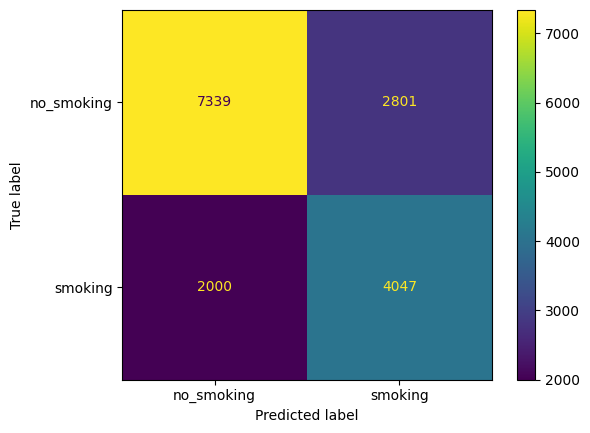

In [58]:
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay, RocCurveDisplay

gnb = GaussianNB()
gnb.fit(X_train,y_train)

gnb_predict = gnb.predict(X_test)
ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test, display_labels=["no_smoking", "smoking"])


*KNN*

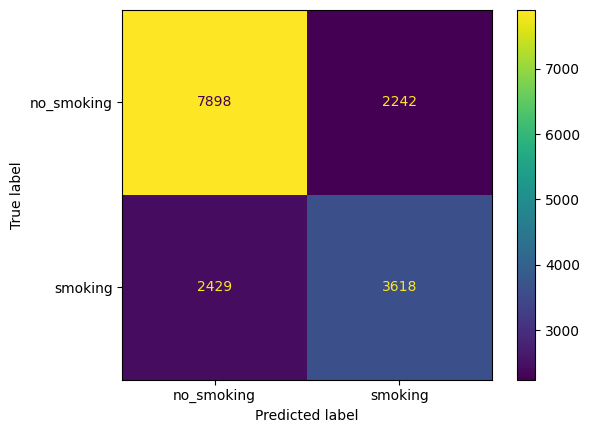

In [59]:
knn =  KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn.predict(X_test)
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, display_labels=["no_smoking", "smoking"])

*Decision Trees*

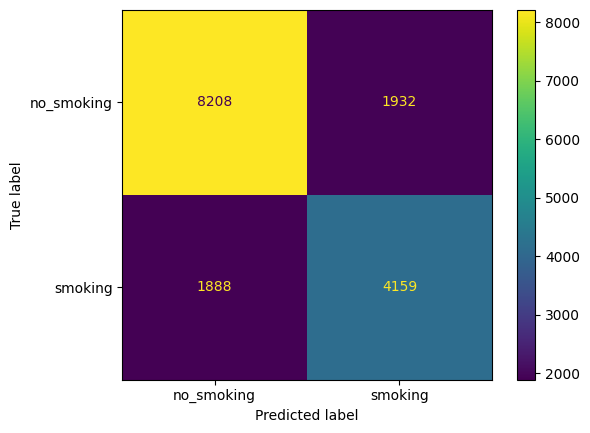

In [60]:
from sklearn import tree

clf_tree=tree.DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    min_samples_split=2,
    min_impurity_decrease=0.0
    ).fit(X_train, y_train)

pred = clf_tree.predict(X_test)
ConfusionMatrixDisplay.from_estimator(clf_tree, X_test, y_test, display_labels=["no_smoking", "smoking"])


In [61]:
cv=50

for clf, label in zip([gnb, knn, clf_tree], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))


Accuracy: 0.700 [Naive Bayes]
Accuracy: 0.720 [Knn (3)]
Accuracy: 0.804 [Dec. Tree]


*Voting clasifier*

In [62]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

eclf = VotingClassifier(estimators=[('nb', gnb), ('knn3', knn), ('dt', clf_tree)], voting='hard')
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))

Accuracy: 0.774 [Majority Voting]


In [63]:
eclf = VotingClassifier(estimators=[('nb', gnb), ('knn3', knn), ('dt', clf_tree)],voting='soft', weights=[2,1,2])
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.800 [Weighted Voting]


**Bagging**

In [64]:
from sklearn.ensemble import BaggingClassifier

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

Accuracy: 0.753 [1]
Accuracy: 0.756 [2]
Accuracy: 0.811 [5]
Accuracy: 0.824 [10]
Accuracy: 0.834 [20]
Accuracy: 0.843 [50]
Accuracy: 0.844 [100]
Accuracy: 0.845 [200]


Accuracy: 0.8432095046854083


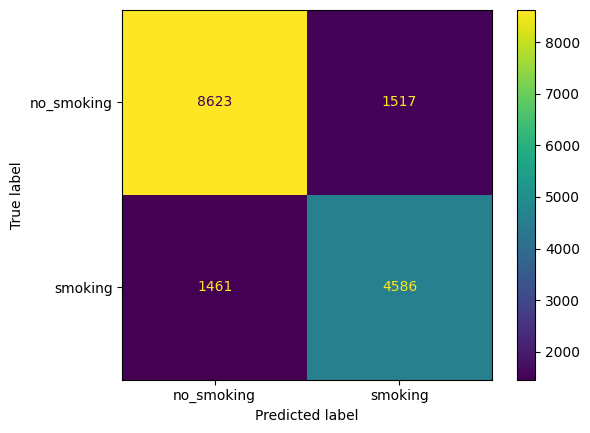

In [68]:
# We will use 50 as number of estimators in order to see the confusion matrix. Eventhough, it is not the best, it is the one that has the best balance between accuracy and computational cost.
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=50).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(bag_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lb[5]))

In [65]:
lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=nest,max_features=0.35), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())


Accuracy: 0.703 [1]
Accuracy: 0.726 [2]
Accuracy: 0.781 [5]
Accuracy: 0.801 [10]
Accuracy: 0.813 [20]
Accuracy: 0.825 [50]
Accuracy: 0.830 [100]
Accuracy: 0.832 [200]


Accuracy: 0.8295328321834345


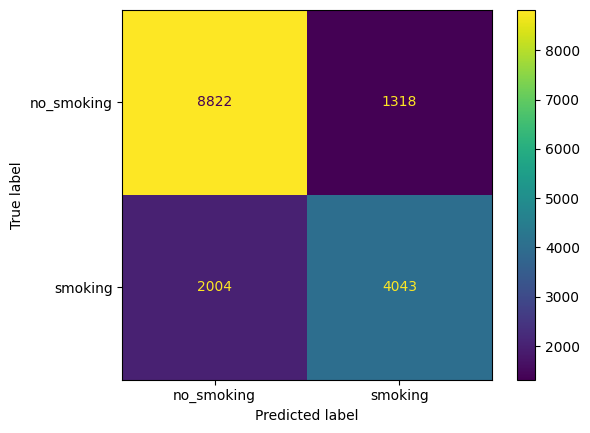

In [71]:
# We will use 100 as number of estimators in order to see the confusion matrix. Eventhough, it is not the best, it is the one that has the best balance between accuracy and computational cost.
bag_clf_features = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=100, max_features=0.35).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(bag_clf_features, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lb2[6]))

**Random Forest**

In [72]:
from sklearn.ensemble import RandomForestClassifier

lrf=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.749 [1]
Accuracy: 0.755 [2]
Accuracy: 0.811 [5]
Accuracy: 0.826 [10]
Accuracy: 0.836 [20]
Accuracy: 0.844 [50]
Accuracy: 0.849 [100]
Accuracy: 0.849 [200]


Accuracy: 0.8486954999485121


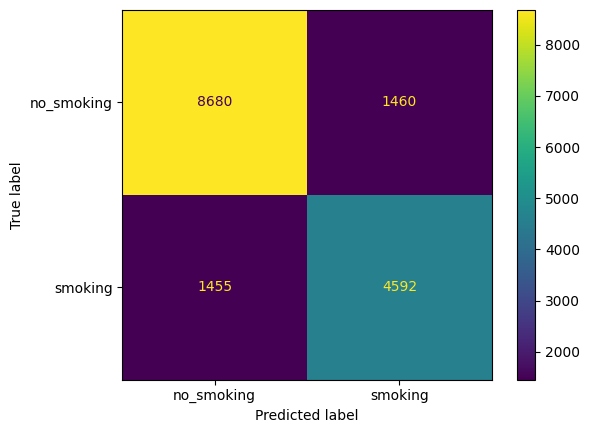

In [75]:
# We will use 100 as number of estimators in order to see the confusion matrix. Is the value that achieves a better accuracy.
rf_clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lrf[6]))

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

lext=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(ExtraTreesClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())

Accuracy: 0.795 [1]
Accuracy: 0.801 [2]
Accuracy: 0.820 [5]
Accuracy: 0.827 [10]
Accuracy: 0.836 [20]
Accuracy: 0.839 [50]
Accuracy: 0.844 [100]
Accuracy: 0.845 [200]


Accuracy: 0.8439326880170254


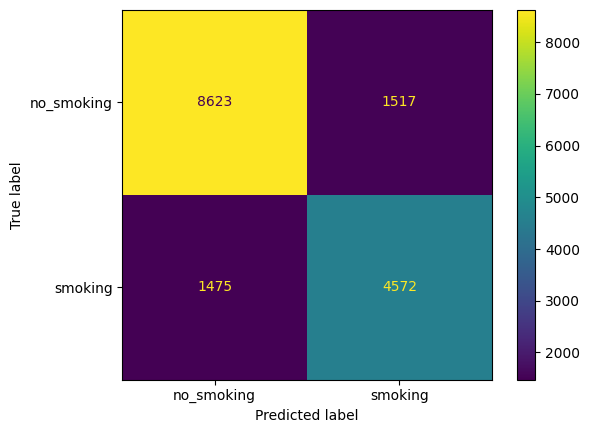

In [76]:
# We will use 100 as number of estimators in order to see the confusion matrix. Eventhough, it is not the best, it is the one that has the best balance between accuracy and computational cost.
rf_clf = ExtraTreesClassifier(n_estimators=100).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lext[6]))

**Boosting**

In [77]:
from sklearn.ensemble import AdaBoostClassifier

lboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())

Accuracy: 0.665 [1]
Accuracy: 0.718 [2]
Accuracy: 0.720 [5]
Accuracy: 0.723 [10]
Accuracy: 0.734 [20]
Accuracy: 0.742 [50]
Accuracy: 0.745 [100]
Accuracy: 0.747 [200]


Accuracy: 0.7448299866131193


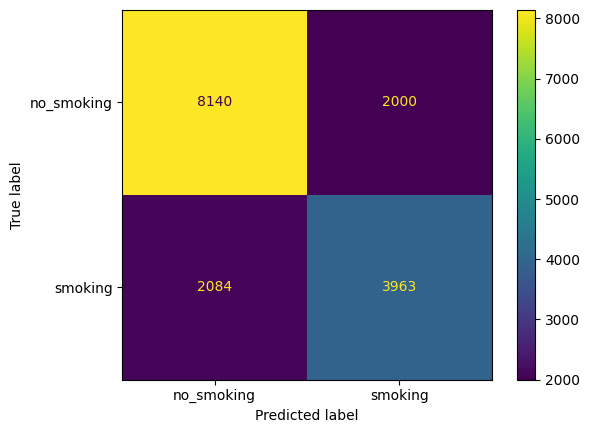

In [80]:
# We will use 200 as number of estimators in order to see the confusion matrix. It is the value that achieves a better accuracy and doesn't have a bad execution time in comparison to the other nest values.
ab_clf = AdaBoostClassifier(n_estimators=200).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(ab_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lboo[6]))

In [78]:
from sklearn.ensemble import AdaBoostClassifier

lboodt=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())

Accuracy: 0.725 [1]
Accuracy: 0.734 [2]
Accuracy: 0.739 [5]
Accuracy: 0.742 [10]
Accuracy: 0.745 [20]
Accuracy: 0.750 [50]
Accuracy: 0.757 [100]
Accuracy: 0.779 [200]


Accuracy: 0.7448299866131193


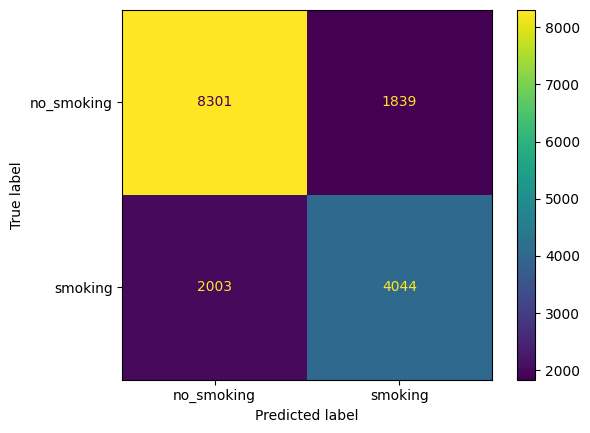

In [81]:
# We will use 200 as number of estimators in order to see the confusion matrix. It is the value that achieves a better accuracy and doesn't have a bad execution time in comparison to the other nest values.
ab_tree_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=200).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(ab_tree_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lboo[6]))

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

lgbboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(GradientBoostingClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lgbboo.append(scores.mean())

Accuracy: 0.626 [1]
Accuracy: 0.626 [2]
Accuracy: 0.658 [5]
Accuracy: 0.719 [10]
Accuracy: 0.730 [20]
Accuracy: 0.744 [50]
Accuracy: 0.751 [100]
Accuracy: 0.755 [200]


Accuracy: 0.7448299866131193


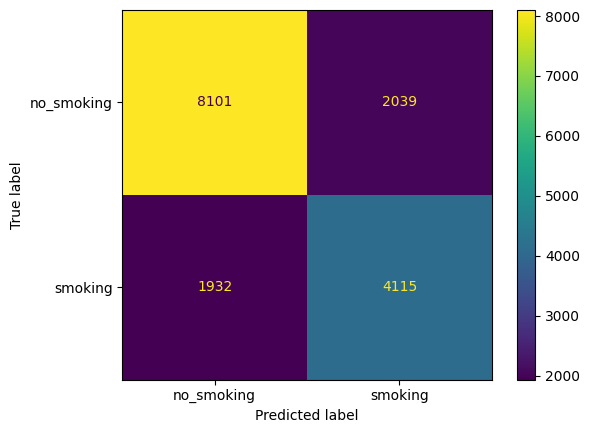

In [83]:
# We will use 200 as number of estimators in order to see the confusion matrix. It is the value that achieves a better accuracy and doesn't have a bad execution time in comparison to the other nest values.
gb_clf = GradientBoostingClassifier(n_estimators=200).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(gb_clf, X_test, y_test, display_labels=["no_smoking", "smoking"])

print("Accuracy: " +  str(lboo[6]))

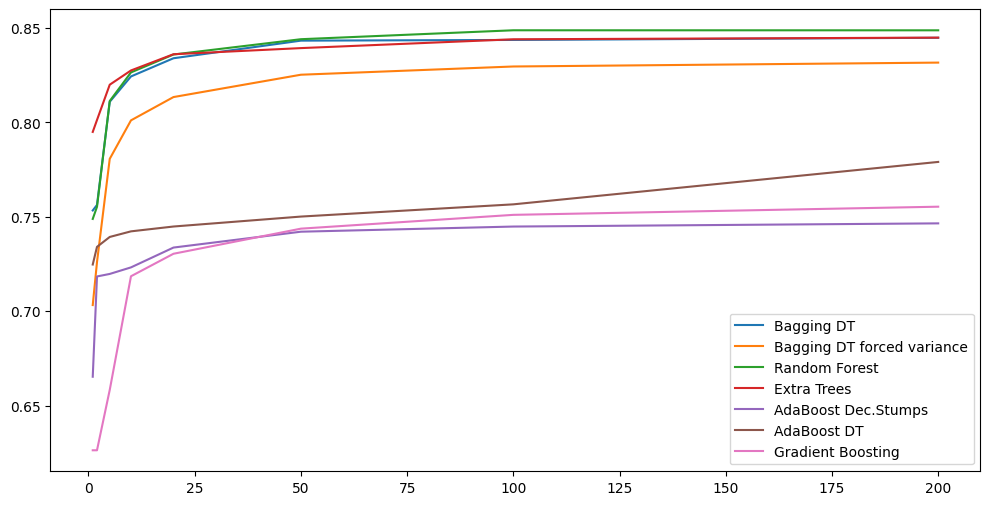

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')

plt.show()

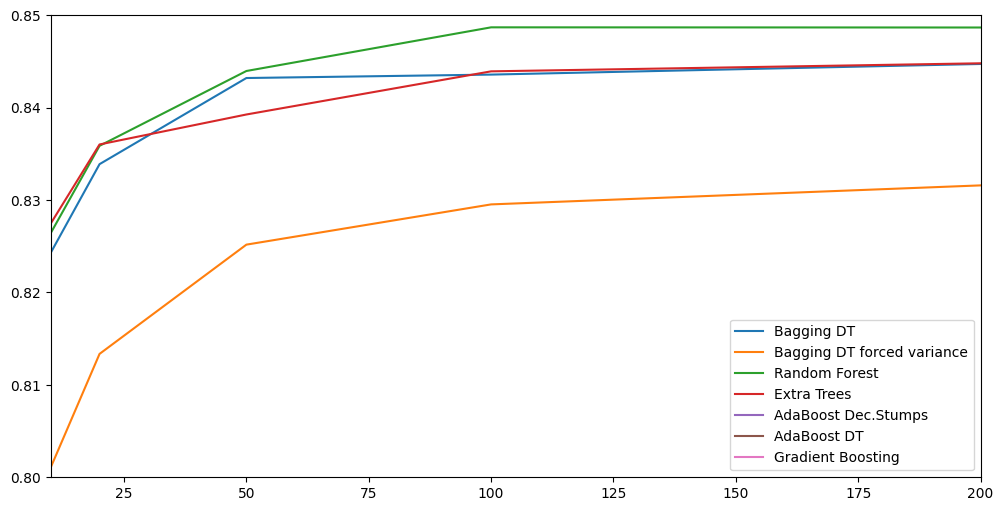

In [86]:
plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')
plt.xlim(10,200)
plt.ylim(0.80,0.85)
plt.show()

**Feature Selection with Forests of trees**

In [87]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, y)
print(clf.feature_importances_)  

[0.04295248 0.12417084 0.0491805  0.03538755 0.03492523 0.00197037
 0.00196179 0.059929   0.06168361 0.07018293 0.08468853 0.06344275
 0.11813877 0.00602889 0.04631205 0.06559084 0.11321172 0.00945198
 0.01079016]


In [89]:
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings("ignore", category=UserWarning)

model = SelectFromModel(clf, prefit=True, threshold=0.05)
X_new = model.transform(X)
print(X_new.shape)

print(np.mean(cross_val_score(KNeighborsClassifier(), X=X, y=y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(KNeighborsClassifier(), X=X_new, y=y, cv=cv, scoring='accuracy')))

(53956, 9)
0.7199581059279855
0.7148050835821921


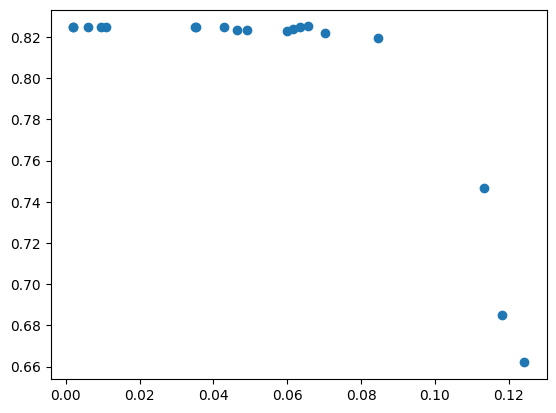

Best threshold:  0.06559083720189281


In [90]:
thresholds=clf.feature_importances_

l=[]
lparval=[]
for threshold in thresholds:
    model = SelectFromModel(clf, prefit=True, threshold=threshold)
    X_new = model.transform(X)
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = KNeighborsClassifier()
    clf2 = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
    clf2.fit(X, y)
    parval=clf2.best_params_
    clf3 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
    acc = np.mean(cross_val_score(clf3, X=X_new, y=y, cv=cv, scoring='accuracy'))
    l.append(acc)
    lparval.append(parval)
    
plt.scatter(thresholds,l)
plt.show()

print('Best threshold: ',thresholds[np.argmax(l)])

In [92]:
parval=lparval[np.argmax(l)]
model = SelectFromModel(clf, prefit=True, threshold=thresholds[np.argmax(l)])
X_new = model.transform(X)
print(X_new.shape)
print(parval['n_neighbors'])

print('Original: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy')))
print('With FS: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights']), X=X_new, y=y, cv=cv, scoring='accuracy')))

(53956, 6)
29
Original:  0.7926143205299832
With FS:  0.8251210997837504
